In [1]:
%matplotlib inline
from __future__ import print_function, division, absolute_import
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from pyuvwsim import evaluate_baseline_uvw_ha_dec
from math import radians, degrees, pi, ceil, sin, asin, log10

In [44]:
# Settings
# http://www.vla.nrao.edu/genpub/overview/
lat = radians(34 + 4.0 / 60.0 + 43.497 / 3600.0)  
lon = -radians(107 + 37 / 60 + 3.819 / 3600.0)
dec = -radians(30) + (lat - radians(30))
ha_min = -0.0
ha_max = +0.0
dump_time = 10 # min
duration = ha_max - ha_min
num_times = 1 if duration == 0.0 \
    else ((duration) * 60) // dump_time  # 1 sample every 10 min
freq_hz = 1000.0e6
oversampling = 2.4
dish_d = 25.0
res_n = 10
res_bmin = None
res_bmax = None

In [45]:
# Load CASA VLA-C XYZ (ECEF) coordinates.
coords = np.loadtxt('../models/vla.c.cfg')
x, y, z = coords[:, 0], coords[:, 1], coords[:, 2]

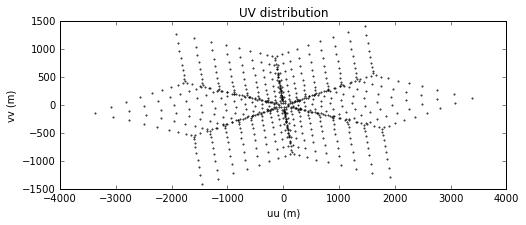

In [46]:
# Generate UV coordinates
uu, vv, ww = np.array([]), np.array([]), np.array([])
ha1_rad = (ha_min / 24) * (2 * pi)
ha2_rad = (ha_max / 24) * (2 * pi)
for i, ha in enumerate(np.linspace(ha1_rad, ha2_rad, num_times)):
    uu_, vv_, ww_ = evaluate_baseline_uvw_ha_dec(x, y, z, ha - lon, dec)
    uu, vv, ww = np.append(uu, uu_), np.append(vv, vv_), np.append(ww, ww_)
        
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, aspect='equal')
ax.plot(uu, vv, '.', color='k', ms=3.0, alpha=0.7)
ax.plot(-uu, -vv, '.', color='k', ms=3.0, alpha=0.7)
ax.set_xlabel('uu (m)')
ax.set_ylabel('vv (m)')
ax.set_title('UV distribution')
plt.show()

In [47]:
# Convert to r, theta
uu_ = np.copy(uu)
vv_ = np.copy(vv)
r = (uu_**2 + vv_**2)**0.5
theta = np.arctan2(vv_, uu_)
theta[theta < 0.0] += pi

In [48]:
# Load iAntConfig results
iac_data = np.loadtxt('/Users/bmort/Desktop/vla_c_snapshot.10x3.txt', 
                      skiprows=1)
iac_r, iac_uvgap = iac_data[:, 0], iac_data[:, 2]

0 2 - 1 [ 1.]
1 2 - 3 [ 1.    0.31  0.04]
2 2 - 1 [ 1.]
3 2 - 0 []
4 2 - 2 [ 1.    0.43]
5 2 - 9 [ 1.    0.39  0.23  0.16  0.04  0.1   0.11  0.1   0.02]
6 2 - 1 [ 1.]
7 2 - 1 [ 1.]
8 2 - 1 [ 1.]
9 2 - 2 [ 1.    0.31]


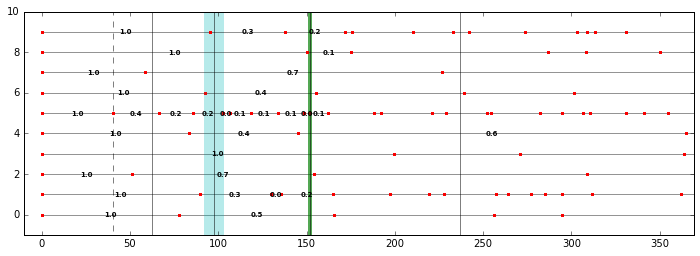

 1 :   62.78  1.000 -   62.96  1.000
 2 :   97.76  0.954 -   98.00  0.996
 3 :  152.22  0.806 -  152.56  0.987
 4 :  237.04  0.620 -  237.50  0.978
 5 :  369.12  0.458 -  369.71  0.958


In [67]:
# Define bin edges
b0 = r.min() if not res_bmin else res_bmin
b1 = r.max() if not res_bmax else res_bmax
r_edges = np.logspace(log10(b0), log10(b1), res_n + 1)
theta_edges = np.linspace(0, pi, res_n + 1)

theta_idx = np.digitize(theta, theta_edges)

uv_gap_im_1 = np.zeros((res_n, res_n))  # paper 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(111)

# Loop over theta bins
for j in range(res_n):
    r_bin = np.append(r[theta_idx == 1 + j], 0.0)
    #r_bin = r[theta_idx == 1 + j]
    r_bin = np.sort(r_bin)
    r_diff = np.diff(r_bin)
    r_diff_norm = r_diff / r_bin[1:]
        
    # Loop over r bins
    for i in range(res_n):
#         i0 = np.where(r_bin <= r_edges[i])[0][-1]
#         i1 = np.where(r_bin > r_edges[i + 1])[0]
#         i1 = r_bin.shape[0] - 1 if len(i1) == 0 else i1[0]
#         bin_diffs = r_diff_norm[:i1-1]
        i1 = np.where(r_bin <= r_edges[i + 1])[0][-1]
        bin_diffs = r_diff_norm[:i1]
        if i == 2:
            ax.plot([r_edges[i + 1], r_edges[i + 1]], [-1, res_n+1], '-', 
                    color='g', lw=4.0, alpha=0.1)
            ax.plot([r_edges[i], r_edges[i]], [-1, res_n+1], '-', 
                    color='c', lw=20.0, alpha=0.03)
            np.set_printoptions(precision=2)
            print(j, i, '-', i1, bin_diffs)
            for p in range(i1+1):
                ax.text(r_bin[p] + r_diff[p] / 2, j, '%.1f' % r_diff_norm[p],
                       va='center', ha='center', fontsize='x-small', 
                        weight='bold')

        uv_gap_im_1[j, i] = numpy.nanmean(bin_diffs) \
            if bin_diffs.shape[0] > 0 else 1.0                       
        ax.plot(r_bin, np.zeros_like(r_bin) + j, 'r.', ms=5.0)
        ax.plot([0, 3500], [j, j], 'k-', alpha=0.05)
    
ax.plot([r_edges[0], r_edges[0]], ax.get_ylim(), 'k--', alpha=0.5)   
for i in range(1, res_n + 1):
    ax.plot([r_edges[i], r_edges[i]], ax.get_ylim(), 'k-', alpha=0.5)   
    
ax.set_xlim(-10, r_edges[5])
ax.set_ylim(-1, res_n)
plt.show()

# Convert to radial profile
uv_gap_r_1 = np.zeros(res_n)

for i in range(res_n):
    uv_gap_r_1[i] = np.mean(uv_gap_im_1[:, i])
    
for i in range(5):
    #ax.text()
    print('%2i : %7.2f %6.3f' % (i + 1, r_edges[i + 1], uv_gap_r_1[i]), end=' ')
    print('- %7.2f %6.3f' % (iac_r[i], iac_uvgap[i]))

<IPython.core.display.Javascript object>


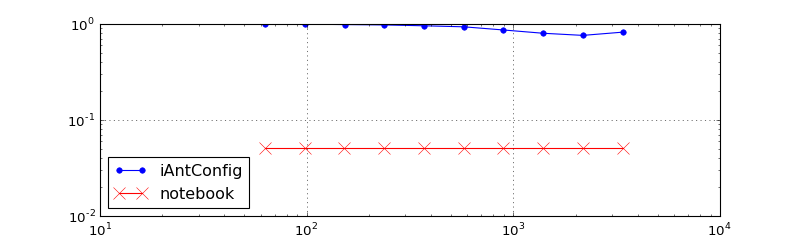

In [41]:
fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(111)
ax.plot(iac_r, iac_uvgap, '.-', color='b', ms=10.0, label='iAntConfig')
ax.plot(r_edges[1:], uv_gap_r_1, 'x-', color='r', ms=10.0, label='notebook')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True)
ax.legend(loc=3)
plt.show()

In [ ]:
  
    
#     r_diff = np.diff(r_values)
#     r_diff_norm = r_diff / r_values[1:]
    
#     # Loop over r bins (within the theta bin)
#     for i in range(num_bins):
#         # Index between
        
#         d0 = np.where(values <= r_edges[i])[0][-1]
#         d1 = np.where(values > r_edges[i + 1])[0]      
#         d1 = r_values.shape[0] - 1 if len(d1) == 0 else d1[0]
#         bin_diffs = r_diff_norm[d0:d1]
#         uv_gap_im_1[j, i] = numpy.nanmean(bin_diffs) if bin_diffs.shape[0] > 0 else 1.0

#         rmax_ = r_edges[i + 1]
#         x_b = np.append(r_values, rmax_)
#         x_b = np.sort(x_b)
#         x_b = x_b[x_b < rmax_]
#         uv_gap_im_2[j, i] = np.sum(np.diff(x_b)**2 / x_b[1:]) / rmax_
    
# # fig = plt.figure(figsize=(12, 5))
# # ax = fig.add_subplot(121)
# # image = np.transpose(uv_gap_im)
# # extent = [theta_edges[0], theta_edges[-1],
# #           r_edges[0]/1.0e3, r_edges[-1]/1.0e3]
# # im = ax.imshow(image, interpolation='nearest', 
# #                origin='lower', cmap='jet', extent=extent, 
# #                norm=LogNorm(vmax=0.225))
# # ax.figure.colorbar(im, ax=ax)
# # ax.set_xlabel('theta')
# # ax.set_ylabel('r (km)')

# # ax = fig.add_subplot(122)
# # image = np.transpose(uv_gap_im)
# # extent = [theta_edges[0], theta_edges[-1],
# #           r_edges[0]/1.0e3, r_edges[-1]/1.0e3]
# # im = ax.imshow(image, interpolation='nearest', 
# #                origin='lower', cmap='jet', extent=extent)
# # ax.figure.colorbar(im, ax=ax)
# # ax.set_xlabel('theta')
# # ax.set_ylabel('r (km)')
# # plt.show()

# # fig = plt.figure(figsize=(5, 5))
# # ax = fig.add_subplot(111)
# # image = np.transpose(uv_gap_im_2)
# # extent = [theta_edges[0], theta_edges[-1],
# #           r_edges[0]/1.0e3, r_edges[-1]/1.0e3]
# # im = ax.imshow(image, interpolation='nearest', 
# #                origin='lower', cmap='jet', extent=extent)
# # ax.figure.colorbar(im, ax=ax)
# # ax.set_xlabel('theta')
# # ax.set_ylabel('r (km)')
# # plt.show()

In [ ]:
print(data[:5, 1])
print(data[-1, 1])
r3d = (uu**2 + vv**2 + ww**2)**0.5
print(r.max(), r3d.max())
e__ = np.logspace(np.log10(1), np.log10(data[-1, 1]), num_bins + 1)
print(e__[-5:])